In [1]:
from primitives.primitives import *
from cirq import Circuit, LineQid, measure, sample, Simulator
from scipy.linalg import expm
import matplotlib.pyplot as plt
from numpy.linalg import eig
import re
from scipy import sparse
from scipy.constants import hbar

simulator = Simulator()

## t-V model definition

One-dimensional spinless t-V model (range=1):

$H = -t \sum_{i=1}^{L} \left( c_i^\dagger c_{i+1} + h.c.\right) + V \sum_{i=1}^L n_i n_{i+1}$

In the 2D case we have to define horizontal and vertical hopping operators.

### Horizontal hopping operators

$H_x^{hop} (i, i+1) = i \Gamma^1_{i} \Gamma^2_{i+1} \left(\tilde \Gamma_i -\tilde\Gamma_{i+1}\right)$

In [2]:
x_hop_matrix = 1j * TensorProduct(sy_gamma_1 * sy_gamma_5, sy_gamma_2) - 1j * TensorProduct(sy_gamma_1, sy_gamma_2 * sy_gamma_5)
x_hop_matrix /= 2
class HopXGate(Gate):
    """Horizontal hopping gate."""
    def _qid_shape_(self):
        return (4, 4)
    def _unitary_(self):
        return np.array(x_hop_matrix, dtype=np.complex128)
    def _circuit_diagram_info_(self, args):
        return ["H_x(r)", "H_x(r+1)"]
x_hop_matrix

Matrix([
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0, -1.0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0, 1.0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0, 1.0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0, -1.0,   0, 0],
[0,    0, 1.0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0, -1.0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0, -1.0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,  

### Vertical hopping operators

$H_y^{hop} (i, i+1) = i \Gamma^3_{i} \Gamma^4_{i+1} \left(\tilde \Gamma_i -\tilde\Gamma_{i+1}\right)$

In [3]:
y_hop_matrix = 1j * TensorProduct(sy_gamma_3 * sy_gamma_5, sy_gamma_4) - 1j * TensorProduct(sy_gamma_3, sy_gamma_4 * sy_gamma_5)
y_hop_matrix /= 2
class HopYGate(Gate):
    """Vertical hopping gate."""
    def _qid_shape_(self):
        return (4, 4)
    def _unitary_(self):
        return np.array(y_hop_matrix, dtype=np.complex128)
    def _circuit_diagram_info_(self, args):
        return ["H_y(r)", "H_y(r+1)"]
y_hop_matrix

Matrix([
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0, 1.0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0, 1.0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0, 1.0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0, 1.0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0, -1.0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0, -1.0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0, -1.0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   

### Number operator

$n_i = \frac{1}{2} - \frac{1}{2}\tilde \Gamma_i$

In [4]:
number_matrix = 0.5 * (sy_id - sy_gamma_5)
class NumberGate(Gate):
    """Number gate."""
    def _qid_shape_(self):
        return (4,)
    def _unitary_(self):
        return np.array(number_matrix, dtype=np.complex128)
    def _circuit_diagram_info_(self, args):
        return ["n(r)"]
number_matrix

Matrix([
[0,   0,   0, 0],
[0, 1.0,   0, 0],
[0,   0, 1.0, 0],
[0,   0,   0, 0]])

In [5]:
double_number_matrix = TensorProduct(number_matrix, number_matrix)
class DoubleNumberGate(Gate):
    """Double number gate."""
    def _qid_shape_(self):
        return (4,4)
    def _unitary_(self):
        return np.array(double_number_matrix, dtype=np.complex128)
    def _circuit_diagram_info_(self, args):
        return ["n(r)", "n(r+1)"]
double_number_matrix

Matrix([
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1.0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0, 1.0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0, 1.0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0, 1.0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0]])

### Evolution gates

In [6]:
def taylor_expm(Hmat, n_order=3, dt=0.1):  # order of the error in dt
    print("Hmat = ", Hmat.shape)
    print(dt)
    Hn = np.eye(Hmat.shape[0], dtype=complex)  # order H^n
    coeffn = complex(1)
    exp_ham_dt = Hn

    for n in range(1, n_order):
        coeffn *= -1j * dt / n
        Hn = Hn @ Hmat
        exp_ham_dt = exp_ham_dt + coeffn * Hn
    return exp_ham_dt

In [7]:
dt = 0.2
order = 10

a = np.array([[0, 1, 2], [1, 2, 3], [4, 5, 6]], dtype=np.complex128)
ta = taylor_expm(a, order, dt)
ea = expm(-1j * dt * a)

(np.isclose(ta, ea, 1e-5)).all()

Hmat =  (3, 3)
0.2


False

In [8]:
def evolve_gate(gate):
    class evolved(Gate):
        def __init__(self, C=1, t=0.1, *args, **kwargs):
            gate_mat = np.array(gate()._unitary_(), dtype=np.complex128)
            if (gate_mat != np.conjugate(gate_mat.T)).any():
                print("Not hermitian")
            self.C = C  # coefficient
            self.t = t  # evolution time
            self.matrix = np.array(expm(-1j * self.t * self.C * gate_mat), dtype=np.complex128)
            super().__init__(*args, **kwargs)
            
        def _qid_shape_(self):
            return gate()._qid_shape_()
        def _circuit_diagram_info_(self, args):
            return gate()._circuit_diagram_info_(args)
        def _unitary_(self):
            return self.matrix
    return evolved

In [9]:
rtol = 1e-7

def commute(a, b):
    c = a@b
    d = b@a
    return np.isclose(np.array(c-d, dtype=np.complex128), np.zeros(c.shape), rtol).all()

In [10]:
# example potential 
evolution_pot = evolve_gate(DoubleNumberGate)(C = 0.01, t = 5)
b = evolution_pot._unitary_()
print(f"Unitary: {np.isclose(np.conjugate(b).T @ b, np.eye(b.shape[0]), rtol).all()}")
print(f"Commute with Hpot: {commute(b, double_number_matrix)}")
print(f"Commute with HkinX: {commute(b, x_hop_matrix)}")
print(f"Commute with HkinY: {commute(b, y_hop_matrix)}")

Unitary: True
Commute with Hpot: True
Commute with HkinX: True
Commute with HkinY: True


In [11]:
# example hopping 
evolution_hop_x = evolve_gate(HopXGate)(C = -1, t = 5)
b = evolution_hop_x._unitary_()
print(f"Unitary: {np.isclose(np.conjugate(b).T @ b, np.eye(b.shape[0]), rtol).all()}")
print(f"Commute with Hpot: {commute(b, double_number_matrix)}")
print(f"Commute with HkinX: {commute(b, x_hop_matrix)}")
print(f"Commute with HkinY: {commute(b, y_hop_matrix)}")

Unitary: True
Commute with Hpot: True
Commute with HkinX: True
Commute with HkinY: True


In [12]:
# example hopping 
evolution_hop_y = evolve_gate(HopYGate)(C = -1, t = 5)
b = evolution_hop_y._unitary_()
print(f"Unitary: {np.isclose(np.conjugate(b).T @ b, np.eye(b.shape[0]), rtol).all()}")
print(f"Commute with Hpot: {commute(b, double_number_matrix)}")
print(f"Commute with HkinX: {commute(b, x_hop_matrix)}")
print(f"Commute with HkinY: {commute(b, y_hop_matrix)}")

Unitary: True
Commute with Hpot: True
Commute with HkinX: True
Commute with HkinY: True


In [13]:
commute(evolution_hop_x._unitary_(), evolution_hop_y._unitary_())

True

## Evolving a state

In [66]:
def evolve(qudits, temps, initial=None, T=1, V=0):

    if initial is None:
        initial = []

    if len(temps) > 1:
        evolution_number = evolve_gate(DoubleNumberGate)(C=V, t = temps[1]-temps[0])
        evolution_horizontal_hop = evolve_gate(HopXGate)(C=T/2, t = temps[1]-temps[0])
        evolution_vertical_hop = evolve_gate(HopYGate)(C=T/2, t = temps[1]-temps[0])
    rows, cols = qudits.shape
    results = []
    evolution_circuit = []
    for idx, t in enumerate(temps):

        if t != 0:    
            # Hopping part
            for row in range(rows):
                for col in range(cols):
                    # horizontal interaction
                    if col != cols - 1:
                        a = qudits[row][col]
                        b = qudits[row][col+1]
                        evolution_circuit.append(evolution_horizontal_hop(a, b))
                    # vertical interaction
                    if row != rows - 1:
                        a = qudits[row][col]
                        b = qudits[row+1][col]
                        evolution_circuit.append(evolution_vertical_hop(a, b))
            # On-site part
            for row in range(rows):
                for col in range(cols):
                    if row != rows - 1:
                        a = qudits[row][col]
                        b = qudits[row+1][col]
                        evolution_circuit.append(evolution_number(a, b))
                    if col != cols - 1:
                        a = qudits[row][col]
                        b = qudits[row][col+1]
                        evolution_circuit.append(evolution_number(a, b))    
            # Hopping part
            for row in range(rows):
                for col in range(cols):
                    # horizontal interaction
                    if col != cols - 1:
                        a = qudits[row][col]
                        b = qudits[row][col+1]
                        evolution_circuit.append(evolution_horizontal_hop(a, b))
                    # vertical interaction
                    if row != rows - 1:
                        a = qudits[row][col]
                        b = qudits[row+1][col]
                        evolution_circuit.append(evolution_vertical_hop(a, b))
           
        circuit = Circuit([*initial, *evolution_circuit])
        results.append((circuit, simulator.simulate(circuit)))
            
    return results

## Constraints

The constraint is (for every plaquette):
$\Gamma^{23}_{r}\Gamma^{23}_{r+x}\Gamma^{23}_{r+x+y}\Gamma^{23}_{r+y} \tilde\Gamma_r \tilde\Gamma_{r+x+y}= I$

We call the first operator G

In [15]:
G = np.array(TensorProduct(sy_gamma_1*sy_gamma_3, sy_gamma_2*sy_gamma_3, sy_gamma_4*sy_gamma_2, sy_gamma_1*sy_gamma_4),
             dtype=np.complex128)

class Project_Constraint_minus(Gate):
    """Gate that prepare an initial state, from the coefficients."""

    def _qid_shape_(self):
        return (4, 4, 4, 4)

    def _unitary_(self):
        return (np.eye(4**4) - G)/2

    def _circuit_diagram_info_(self, args):
        return ["P-", "P-", "P-", "P-"]

class Project_Constraint(Gate):
    """Gate that prepare an initial state, from the coefficients."""

    def _qid_shape_(self):
        return (4, 4, 4, 4)

    def _unitary_(self):
        return (np.eye(4**4) + G)/2

    def _circuit_diagram_info_(self, args):
        return ["P+", "P+", "P+", "P+"]

### Add fermions

The creation operator for pairs of fermions is:

$f^\dagger_r f^\dagger_{r+x}=i \Gamma^1_r \Gamma^2_{r+x} \frac{(I + \tilde\Gamma_r)(I + \tilde \Gamma_{r+x})}{4}$

In [16]:
class AddHorizontalPair(Gate):
    """Add pair of fermions (r)+(r+x)."""
    
    def _qid_shape_(self):
        return (4, 4)

    def _unitary_(self):
        return np.array(1j * (1/4) * TensorProduct(sy_gamma_1, sy_gamma_2) * TensorProduct(sy_id + sy_gamma_5, sy_id + sy_gamma_5),
                        dtype=np.complex128)

    def _circuit_diagram_info_(self, args):
        return ["f+", "f+"]

In [17]:
class AddVerticalPair(Gate):
    """Add pair of fermions (r)+(r+y)."""
        
    def _qid_shape_(self):
        return (4, 4, 4, 4)

    def _unitary_(self):
        create = 1j * (1/4) * TensorProduct(sy_gamma_1, sy_gamma_2) * TensorProduct(sy_id + sy_gamma_5, sy_id + sy_gamma_5)
        # (r, r+x, r+x+y, r+y)
        # hop vertical
        create_hopped = (
            TensorProduct(sy_id, sy_id, -x_hop_matrix) * 
            TensorProduct(sy_id, y_hop_matrix, sy_id) * 
            TensorProduct(create, sy_id, sy_id)
        )
        return np.array(create_hopped, dtype=np.complex128)
    
    def _circuit_diagram_info_(self, args):
        return ["f+", "/", "/", "f+"]

class AddVerticalPair_2(Gate):
    """Add pair of fermions (r+x)+(r+x+y)."""
        
    def _qid_shape_(self):
        return (4, 4, 4)

    def _unitary_(self):
        create = 1j * (1/4) * TensorProduct(sy_gamma_1, sy_gamma_2) * TensorProduct(sy_id + sy_gamma_5, sy_id + sy_gamma_5)
        # (r, r+x, r+x+y, r+y)
        # hop vertical
        create_hopped = (
            TensorProduct(x_hop_matrix, sy_id) * 
            TensorProduct(sy_id, y_hop_matrix) * 
            TensorProduct(create, sy_id)
        )
        return np.array(create_hopped, dtype=np.complex128)
    
    def _circuit_diagram_info_(self, args):
        return ["/", "f+", "f+"]

In [18]:
class AddDiagonalPair(Gate):
    """Add pair of fermions (r)+(r+x+y)."""
        
    def _qid_shape_(self):
        return (4, 4, 4)

    def _unitary_(self):
        create = 1j * (1/4) * TensorProduct(sy_gamma_1, sy_gamma_2) * TensorProduct(sy_id + sy_gamma_5, sy_id + sy_gamma_5)
        # (r, r+x, r+x+y)
        # hop vertical
        create_hopped = (
            TensorProduct(sy_id, y_hop_matrix) * 
            TensorProduct(create, sy_id)
        )
        return np.array(create_hopped, dtype=np.complex128)
    
    def _circuit_diagram_info_(self, args):
        return ["f+", "/", "f+"]

In [19]:
class AddAntiDiagonalPair(Gate):
    """Add pair of fermions (r+x)+(r+y)."""
        
    def _qid_shape_(self):
        return (4, 4, 4, 4)

    def _unitary_(self):
        create = 1j * (1/4) * TensorProduct(sy_gamma_1, sy_gamma_2) * TensorProduct(sy_id + sy_gamma_5, sy_id + sy_gamma_5)
        # (r, r+x, r+x+y, r+y)
        # hop vertical
        create_hopped = (
            TensorProduct(x_hop_matrix, -x_hop_matrix) * 
            TensorProduct(sy_id, y_hop_matrix, sy_id) * 
            TensorProduct(create, sy_id, sy_id)
        )
        return np.array(create_hopped, dtype=np.complex128)
    
    def _circuit_diagram_info_(self, args):
        return ["/", "f+", "/", "f+"]

In [20]:
class Hopx(Gate):
    """Hop x fermion (r)+(r+x)."""
    
    def _qid_shape_(self):
        return (4, 4)

    def _unitary_(self):
        hop = -1j * TensorProduct(sy_gamma_1, sy_gamma_2 * sy_gamma_5)
        return np.array(hop, dtype=np.complex128)
        
    def _circuit_diagram_info_(self, args):
        return ["S(r)", "S(r+x)"]

In [21]:
class AddCoupledPair(Gate):
    """Add two couple of fermions (r)+(r+x) - (r)+(r+x+1) in superposition."""

    def __init__(self, A=1, B=1, *args, **kwargs):
        self.A = A
        self.B = B
        super().__init__(*args, **kwargs)
    
    def _qid_shape_(self):
        return (4, 4, 4)

    def _unitary_(self):
        create = 1j * (1/4) * TensorProduct(sy_gamma_1, sy_gamma_2) * TensorProduct(sy_id + sy_gamma_5, sy_id + sy_gamma_5)
        create_hopped = TensorProduct(sy_id, y_hop_matrix) * TensorProduct(create, sy_id)
        return np.array(self.A * TensorProduct(create, sy_id) + self.B * create_hopped, dtype=np.complex128)
        
    def _circuit_diagram_info_(self, args):
        return ["f+", "f+/2", "f+/2"]

In [22]:
class AddPlaqPair(Gate):
    """Add superposition of A, B, C, D"""

    def __init__(self, A=1, B=1, C=1, D=1, E=1, F=1, *args, **kwargs):
        self.A = A
        self.B = B        
        self.C = C
        self.D = D
        self.E = E
        self.F = F
        super().__init__(*args, **kwargs)
    
    def _qid_shape_(self):
        return (4, 4, 4, 4)

    def _unitary_(self):
        A = TensorProduct(AddHorizontalPair()._unitary_(), sy_id, sy_id)
        B = TensorProduct(AddDiagonalPair()._unitary_(), sy_id)
        C = AddVerticalPair()._unitary_()
        D = AddAntiDiagonalPair()._unitary_()
        E = TensorProduct(AddVerticalPair_2()._unitary_(), sy_id)
        F = TensorProduct(sy_id, sy_id, Matrix(AddHorizontalPair()._unitary_()))
        total = self.A * A + self.B * B + self.C * C + self.D * D + self.E * E + self.F * F
        return np.array(total, dtype=np.complex128)

    def _circuit_diagram_info_(self, args):
        return ["f+(r)", "f+(r+x)", "f+(r+x+y)", "f+(r+y)"]        

In [23]:
def expectation_value(result, qudits, operator):
    rho = result.density_matrix_of(qudits)
    
    srho = sparse.coo_array(np.array(rho, dtype=np.complex128)) 
    srho /= srho.trace()
    shop = sparse.coo_array(np.array(operator, dtype=np.complex128))
    val = srho @ shop 

    tr = val.trace()
    if np.imag(tr) != 0:
        print(f"Casting {tr} to real")
    return np.real(tr)

## Evolving a 4x2 lattice

In [24]:
coeffs = [np.random.rand(6) + 1j * np.random.rand(6)]
coeffs = [co/np.abs(co) for co in coeffs]
coeffs

[array([0.87806136+0.47854806j, 0.89290143+0.45025218j,
        0.14688749+0.98915321j, 0.82658314+0.56281463j,
        0.59238681+0.80565369j, 0.84171922+0.5399155j ])]

In [74]:
rows = 2
columns = 2

T = -1
V = 0.5

qudits = np.array(LineQid.range(rows * columns, dimension=4)).reshape(rows, columns)

final_time = 0.1
num_steps = 10
dt = final_time/num_steps

temps = np.arange(0, final_time+dt/2, dt)


plaquettes = []
rows, cols = qudits.shape
for row in range(rows):
    for col in range(cols):
        if row != rows - 1 and col != cols - 1:
            pl = [qudits[row][col], 
                  qudits[row][col+1], 
                  qudits[row+1][col+1],
                  qudits[row+1][col]]
            plaquettes.append(pl)
            
# initial circuit that ensures that the correct subspace is used (really?)

projected_subspace = [Project_Constraint()(*pl) for pl in plaquettes]
initial_state = [
    AddPlaqPair(*coeffs[0])(qudits[0][0], qudits[0][1], qudits[1][1], qudits[1][0])
    #AddCoupledPair(1, 3)(qudits[0][0], qudits[0][1], qudits[1][1]),
]
initial_circuit = [*projected_subspace, *initial_state]

# results is a list of tuples, every tuple contains the circuit and the result shots
results = evolve(qudits, temps, initial_circuit, T=T, V=V)

In [68]:
results[1][0]

┌────────────────┐                                                    ┌────────────────┐
0 (d=4): ───P+───f+(r)───────H_x(r)──────H_y(r)─────────────────────────n(r)─────n(r)──────────────H_x(r)──────H_y(r)─────────────────────────
            │    │           │           │                              │        │                 │           │
1 (d=4): ───P+───f+(r+x)─────H_x(r+1)────┼───────H_y(r)─────────────────┼────────n(r+1)───n(r)─────H_x(r+1)────┼───────H_y(r)─────────────────
            │    │                       │       │                      │                 │                    │       │
2 (d=4): ───P+───f+(r+y)─────────────────H_y(r+1)┼───────────H_x(r)─────n(r+1)────────────┼────────n(r)────────H_y(r+1)┼───────────H_x(r)─────
            │    │                               │           │                            │        │                   │           │
3 (d=4): ───P+───f+(r+x+y)───────────────────────H_y(r+1)────H_x(r+1)─────────────────────n(r+1)───n(r+1)──────────────H_y(r+1)────H_x(r+1)───
                                        └────────────────┘                                                    └────────────────┘

## Operators evolution

In [ ]:
line_styles = ['-.', '--', '-.', ':', '-.', '--', '-.', ':']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p']

### Constraints

(-1.1, 1.1)

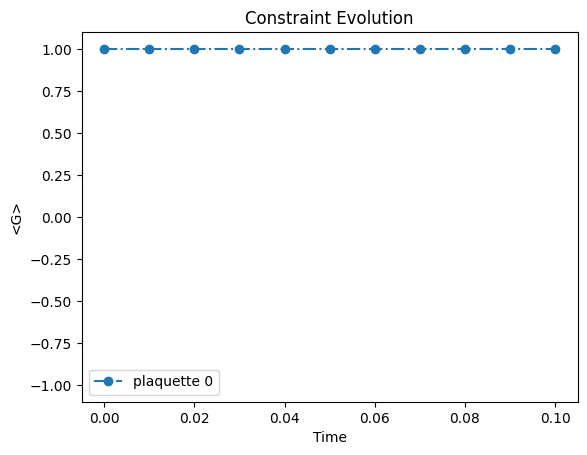

In [77]:
evol_res = {str(idx): [] for idx in range(len(plaquettes))}

for idx, plaquette in enumerate(plaquettes):
    for state in results:
        operator = G
        val = expectation_value(state[1], plaquette, operator)
        evol_res[str(idx)].append(np.abs(val))

for idx, i in enumerate(evol_res):
    plt.plot(temps, evol_res[i], label=f"plaquette {idx}", linestyle=line_styles[idx], marker=markers[idx])
    
plt.title("Constraint Evolution")
plt.xlabel("Time")
plt.ylabel("<G>")
plt.legend()
plt.ylim(-1.1, 1.1)

### Numbers

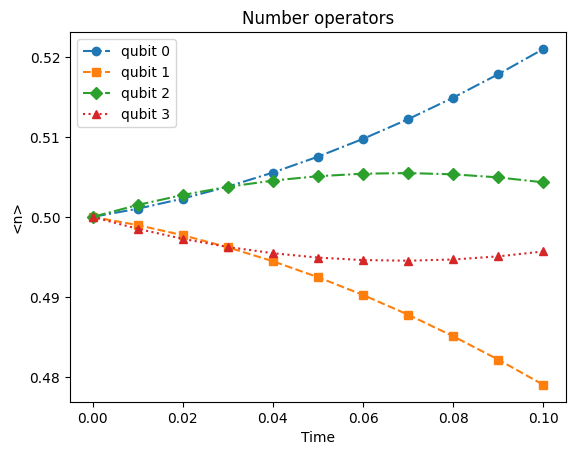

In [78]:
subsystems = [ [idx] for idx in range(len(qudits.flatten()))]
num_evol_res = {str(i[0]): [] for i in subsystems}

for idx, sys in enumerate(subsystems):
    for state in results:
        operator = number_matrix
        val = expectation_value(state[1], [qudits.flatten()[idx]], operator)
        num_evol_res[str(idx)].append(np.abs(val))
        
for i, key in enumerate(num_evol_res):
    plt.plot(temps, num_evol_res[key], label=f"qubit {key}", linestyle=line_styles[i], marker=markers[i])
    
plt.title("Number operators")
plt.xlabel("Time")
plt.ylabel("<n>")
plt.legend()

In [ ]:
num_evol_res

In [ ]:
x_sum = [sum(values[idx] for values in num_evol_res.values()) for idx in range(len(num_evol_res['0']))]
x_sum

### Hamiltonian

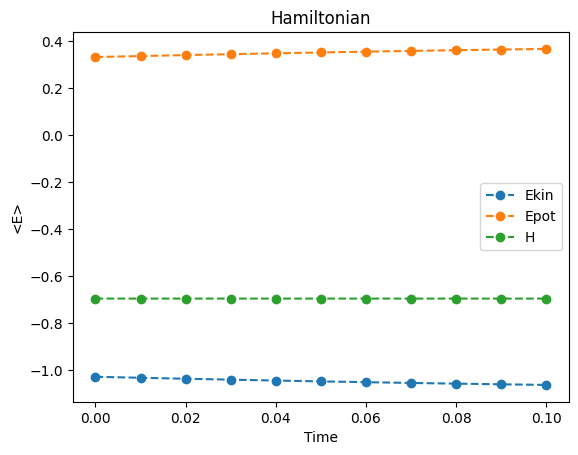

In [75]:
x_hop_couples = []
y_hop_couples = []

rows, cols = qudits.shape
for row in range(rows):
    for col in range(cols):
        if row != rows - 1:
            y_hop_couples.append([qudits[row][col], qudits[row+1][col]])
        if col != cols - 1:
            x_hop_couples.append([qudits[row][col], qudits[row][col+1]])


ekin = []
epot = []

for state in results:
    ham_k = 0
    ham_p = 0
    
    # number term
    couples = x_hop_couples + y_hop_couples
    for couple in couples:
        operator = V * double_number_matrix
        val = expectation_value(state[1], couple, operator)
        ham_p += val

    # x_hop term
    for couple in x_hop_couples:
        operator = T * x_hop_matrix
        val = expectation_value(state[1], couple, operator)
        ham_k += val    
        
    # y_hop term
    for couple in y_hop_couples:
        operator = T * y_hop_matrix
        val = expectation_value(state[1], couple, operator)
        ham_k += val

    ekin.append(ham_k)
    epot.append(ham_p)

plt.plot(temps, ekin, "o--", label="Ekin")
plt.plot(temps, epot, "o--", label="Epot")

ham = [ekin[i] + ep for i, ep in enumerate(epot)]
plt.plot(temps, ham, "o--", label="H")
    
plt.title("Hamiltonian")
plt.xlabel("Time")
plt.ylabel("<E>")
plt.legend()

In [57]:
y_hop_couples

[[cirq.LineQid(0, dimension=4), cirq.LineQid(2, dimension=4)],
 [cirq.LineQid(1, dimension=4), cirq.LineQid(3, dimension=4)]]

In [70]:
# num_steps = 1

N = 4
for idx, t in enumerate(temps):
    print(f"t = {t:.2}\t\tEkin={np.round(ekin[idx], N)}\tPot={np.round(epot[idx], N)}\tH={np.round(ekin[idx]+epot[idx], N)}")

t = 0.0		Ekin=-1.0296	Pot=0.3333	H=-0.6963
t = 0.1		Ekin=-1.0646	Pot=0.368	H=-0.6966


In [73]:
# num_steps = 5

N = 4
for idx, t in enumerate(temps):
    print(f"t = {t:.2}\t\tEkin={np.round(ekin[idx], N)}\tPot={np.round(epot[idx], N)}\tH={np.round(ekin[idx]+epot[idx], N)}")

t = 0.0		Ekin=-1.0296	Pot=0.3333	H=-0.6963
t = 0.02		Ekin=-1.038	Pot=0.3417	H=-0.6963
t = 0.04		Ekin=-1.0457	Pot=0.3494	H=-0.6963
t = 0.06		Ekin=-1.0526	Pot=0.3564	H=-0.6963
t = 0.08		Ekin=-1.0589	Pot=0.3626	H=-0.6963
t = 0.1		Ekin=-1.0643	Pot=0.368	H=-0.6963


In [76]:
# num_steps = 10

N = 4
for idx, t in enumerate(temps):
    print(f"t = {t:.2}\t\tEkin={np.round(ekin[idx], N)}\tPot={np.round(epot[idx], N)}\tH={np.round(ekin[idx]+epot[idx], N)}")

t = 0.0		Ekin=-1.0296	Pot=0.3333	H=-0.6963
t = 0.01		Ekin=-1.0339	Pot=0.3376	H=-0.6963
t = 0.02		Ekin=-1.038	Pot=0.3417	H=-0.6963
t = 0.03		Ekin=-1.0419	Pot=0.3456	H=-0.6963
t = 0.04		Ekin=-1.0457	Pot=0.3494	H=-0.6963
t = 0.05		Ekin=-1.0492	Pot=0.353	H=-0.6963
t = 0.06		Ekin=-1.0526	Pot=0.3564	H=-0.6963
t = 0.07		Ekin=-1.0559	Pot=0.3596	H=-0.6963
t = 0.08		Ekin=-1.0589	Pot=0.3626	H=-0.6963
t = 0.09		Ekin=-1.0617	Pot=0.3654	H=-0.6963
t = 0.1		Ekin=-1.0643	Pot=0.368	H=-0.6963


In [58]:
# num_steps = 1

N = 4
for idx, t in enumerate(temps):
    print(f"t = {t:.2}\t\tEkin={np.round(ekin[idx], N)}\tPot={np.round(epot[idx], N)}\tH={np.round(ekin[idx]+epot[idx], N)}")

t = 0.0		Ekin=-1.0296	Pot=0.3333	H=-0.6963
t = 0.1		Ekin=-1.0563	Pot=0.3694	H=-0.6869


In [61]:
# num_steps = 5

N = 4
for idx, t in enumerate(temps):
    print(f"t = {t:.2}\t\tEkin={np.round(ekin[idx], N)}\tPot={np.round(epot[idx], N)}\tH={np.round(ekin[idx]+epot[idx], N)}")

t = 0.0		Ekin=-1.0296	Pot=0.3333	H=-0.6963
t = 0.02		Ekin=-1.0377	Pot=0.3417	H=-0.696
t = 0.04		Ekin=-1.0451	Pot=0.3495	H=-0.6956
t = 0.06		Ekin=-1.0518	Pot=0.3565	H=-0.6952
t = 0.08		Ekin=-1.0577	Pot=0.3628	H=-0.6949
t = 0.1		Ekin=-1.0628	Pot=0.3683	H=-0.6945


In [65]:
# num_steps = 10

N = 4
for idx, t in enumerate(temps):
    print(f"t = {t:.2}\t\tEkin={np.round(ekin[idx], N)}\tPot={np.round(epot[idx], N)}\tH={np.round(ekin[idx]+epot[idx], N)}")

t = 0.0		Ekin=-1.0296	Pot=0.3333	H=-0.6963
t = 0.01		Ekin=-1.0338	Pot=0.3376	H=-0.6962
t = 0.02		Ekin=-1.0378	Pot=0.3417	H=-0.6961
t = 0.03		Ekin=-1.0417	Pot=0.3457	H=-0.696
t = 0.04		Ekin=-1.0454	Pot=0.3494	H=-0.6959
t = 0.05		Ekin=-1.0489	Pot=0.353	H=-0.6959
t = 0.06		Ekin=-1.0522	Pot=0.3564	H=-0.6958
t = 0.07		Ekin=-1.0553	Pot=0.3597	H=-0.6957
t = 0.08		Ekin=-1.0583	Pot=0.3627	H=-0.6956
t = 0.09		Ekin=-1.061	Pot=0.3655	H=-0.6955
t = 0.1		Ekin=-1.0635	Pot=0.3681	H=-0.6954


In [34]:
# num_steps = 1

N = 4
for idx, t in enumerate(temps):
    print(f"t = {t:.2}\t\tEkin={np.round(ekin[idx], N)}\tPot={np.round(epot[idx], N)}\tH={np.round(ekin[idx]+epot[idx], N)}")

t = 0.0		Ekin=-1.0296	Pot=0.3333	H=-0.6963
t = 0.1		Ekin=-1.0638	Pot=0.368	H=-0.6958


In [39]:
# num_steps = 2

N = 4
for idx, t in enumerate(temps):
    print(f"t = {t:.2}\t\tEkin={np.round(ekin[idx], N)}\tPot={np.round(epot[idx], N)}\tH={np.round(ekin[idx]+epot[idx], N)}")

t = 0.0		Ekin=-1.0296	Pot=0.3333	H=-0.6963
t = 0.05		Ekin=-1.049	Pot=0.353	H=-0.696
t = 0.1		Ekin=-1.064	Pot=0.368	H=-0.696


In [46]:
# num_steps = 4

N = 4
for idx, t in enumerate(temps):
    print(f"t = {t:.2}\t\tEkin={np.round(ekin[idx], N)}\tPot={np.round(epot[idx], N)}\tH={np.round(ekin[idx]+epot[idx], N)}")

t = 0.0		Ekin=-1.0296	Pot=0.3333	H=-0.6963
t = 0.025		Ekin=-1.0399	Pot=0.3437	H=-0.6962
t = 0.05		Ekin=-1.0491	Pot=0.353	H=-0.6962
t = 0.075		Ekin=-1.0572	Pot=0.3611	H=-0.6961
t = 0.1		Ekin=-1.0641	Pot=0.368	H=-0.6961


In [50]:
# num_steps = 10

N = 4
for idx, t in enumerate(temps):
    print(f"t = {t:.2}\t\tEkin={np.round(ekin[idx], N)}\tPot={np.round(epot[idx], N)}\tH={np.round(ekin[idx]+epot[idx], N)}")

t = 0.0		Ekin=-1.0296	Pot=0.3333	H=-0.6963
t = 0.01		Ekin=-1.0339	Pot=0.3376	H=-0.6963
t = 0.02		Ekin=-1.0379	Pot=0.3417	H=-0.6963
t = 0.03		Ekin=-1.0419	Pot=0.3456	H=-0.6962
t = 0.04		Ekin=-1.0456	Pot=0.3494	H=-0.6962
t = 0.05		Ekin=-1.0492	Pot=0.353	H=-0.6962
t = 0.06		Ekin=-1.0526	Pot=0.3564	H=-0.6962
t = 0.07		Ekin=-1.0558	Pot=0.3596	H=-0.6962
t = 0.08		Ekin=-1.0588	Pot=0.3626	H=-0.6962
t = 0.09		Ekin=-1.0616	Pot=0.3654	H=-0.6962
t = 0.1		Ekin=-1.0642	Pot=0.368	H=-0.6962
